# Capstone 2 - Nuclear feature extraction for breast tumor diagnosis
# EDA

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import time

In [4]:
cleaned_data = pd.read_table('cleaned_data',sep=',')
df = cleaned_data.set_index('ID')
df.head()
df.shape

(569, 21)

In [3]:
pd.set_option('display.max_columns', 32)
df.head()

,Diagnosis,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,radius_ext,texture_ext,perimeter_ext,area_ext,smoothness_ext,compactness_ext,concavity_ext,concave_points_ext,symmetry_ext,fractal_dimension_ext
ID,,,,,,,,,,,,,,,,,,,,,
842302,True,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,True,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,True,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,True,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,True,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


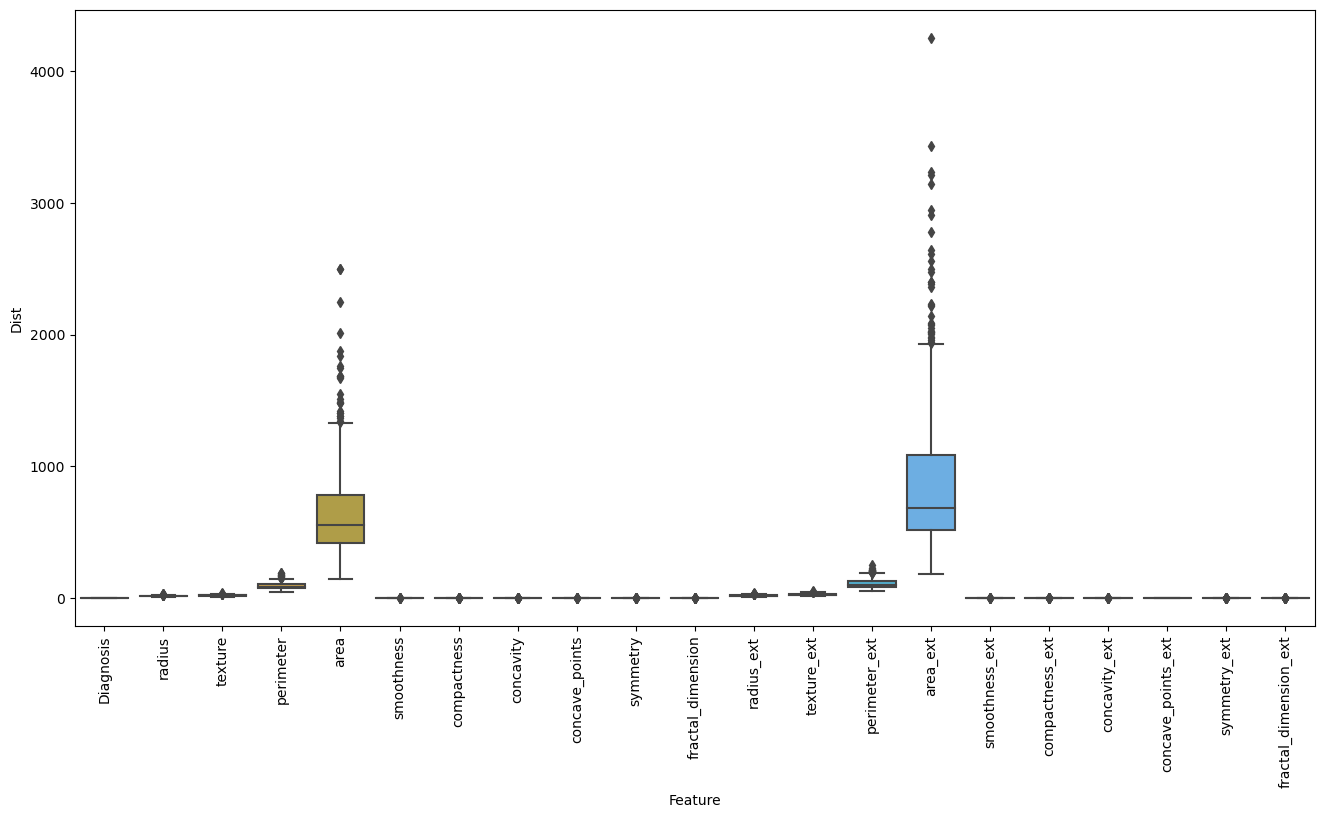

In [4]:
df_melt = pd.melt(cleaned_data,id_vars='ID',var_name='Mean, Extreme',value_vars=df.columns)
plt.subplots(figsize=(16,8))
sns.boxplot(x='Mean, Extreme', y='value', data=df_melt)
plt.xticks(rotation='vertical')
plt.ylabel('Dist')
plt.xlabel('Feature');

Some outliers in area, area_ext, perimeter, and perimeter_ext to keep in mind.

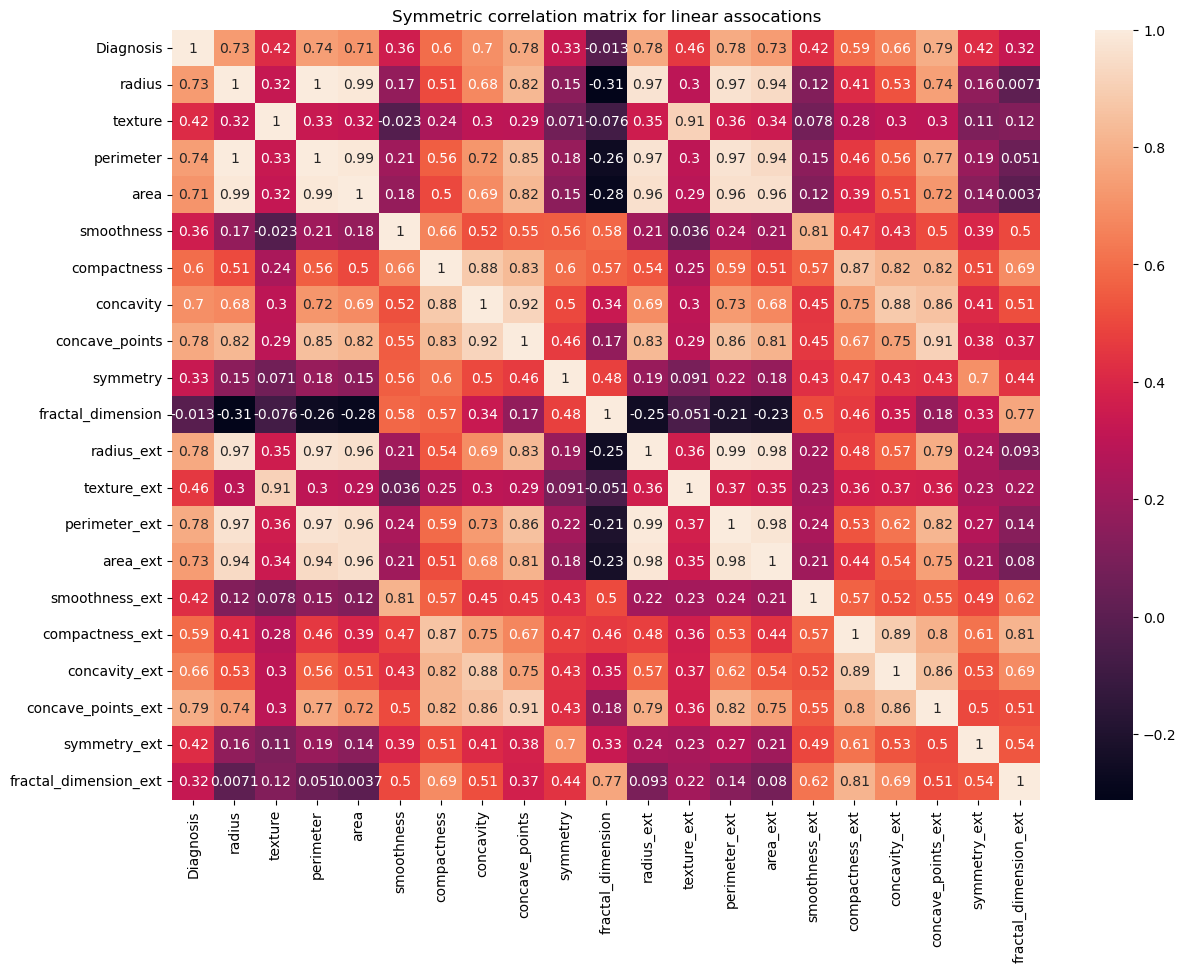

In [5]:
# Basic symmetric heatmap
plt.subplots(figsize=(14,10))
sns.heatmap(df.corr(numeric_only=True),annot=True).set(title='Symmetric correlation matrix for linear assocations');


The features most strongly correlated with diagnosis are: radius, perimeter, area, compactness, concavity, concave_points (mean & ext). Followed by: texture, smoothness, symmetry (mean & ext).

High correlation between area, perimeter, radius (mean & ext). Relatively high correlation between compactness, concavity, and concave points.

In [ ]:
testbins = pd.qcut(df['radius'],5,labels=['1','2','3','4','5'])
testarrbins = np.array(testbins,dtype=object)
testtarget = df.Diagnosis==True
testonefeat = pd.DataFrame(list(zip(testtarget.values,testarrbins))).groupby(1).mean()
testonefeat.plot(kind='barh',title='Radius vs. Malignancy',legend=False,xlabel='Malignant',
                 ylabel='Radius measurement, ascending');

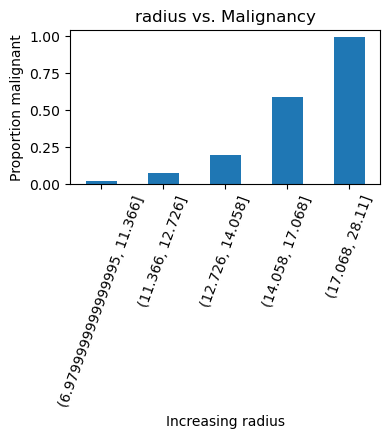

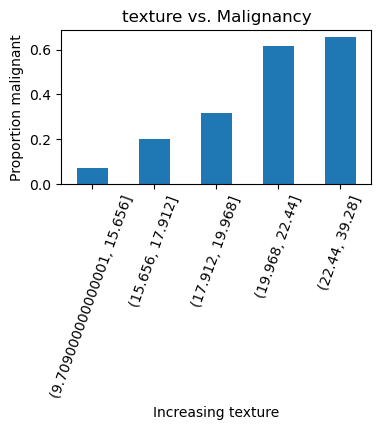

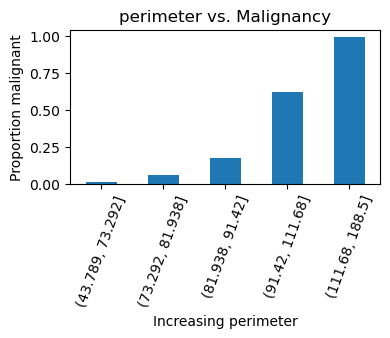

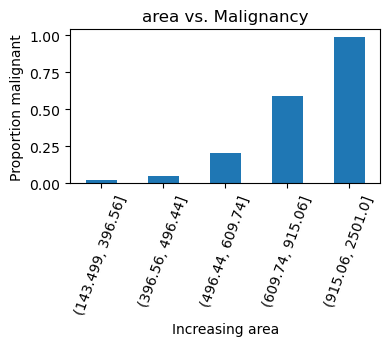

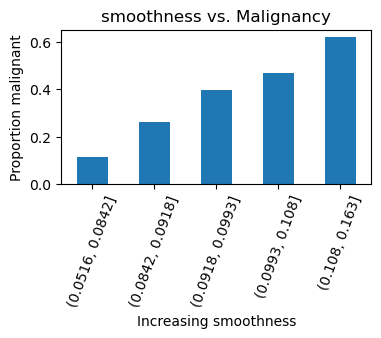

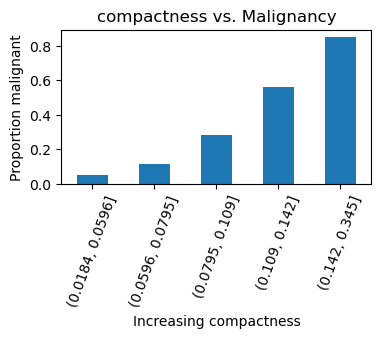

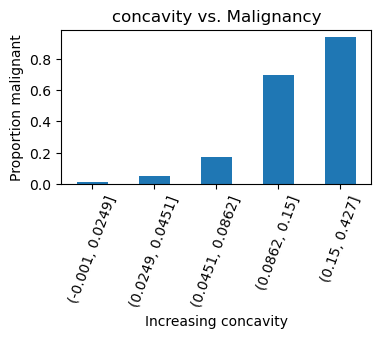

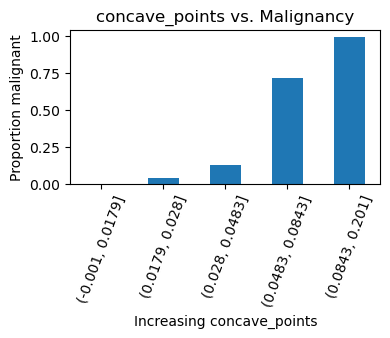

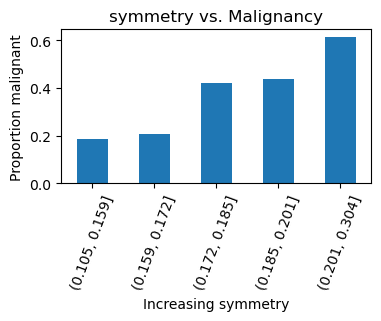

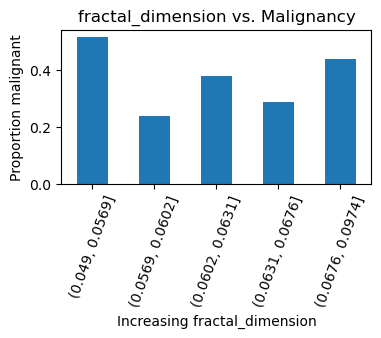

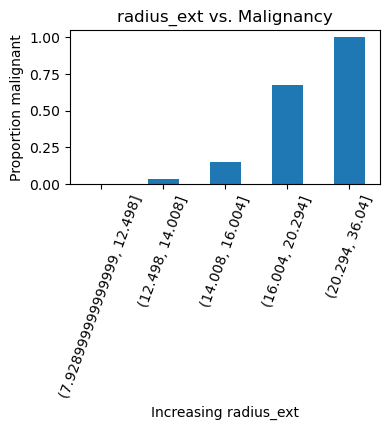

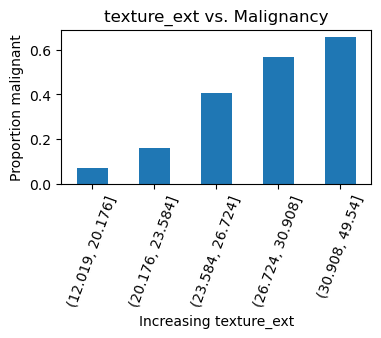

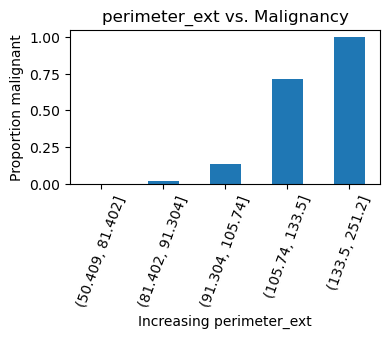

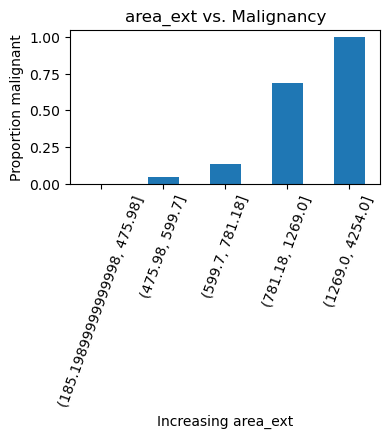

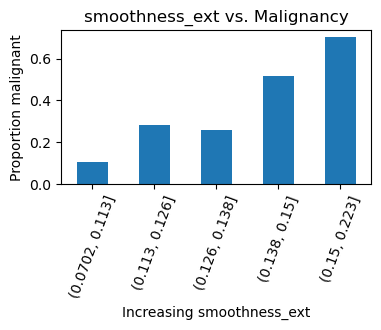

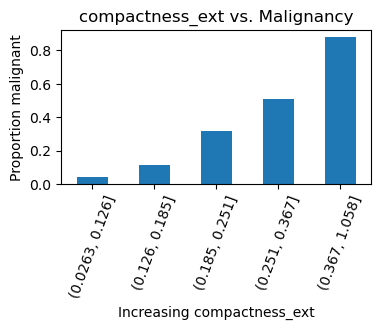

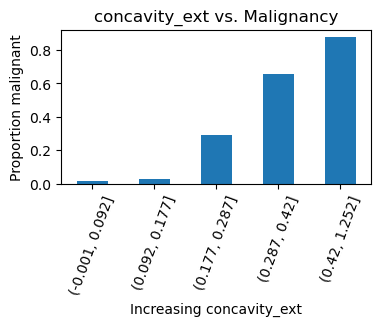

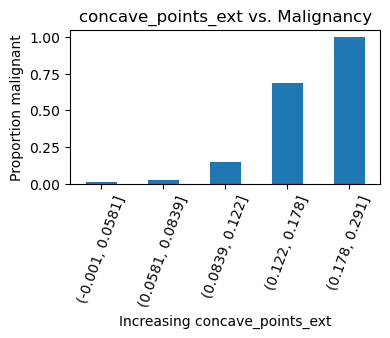

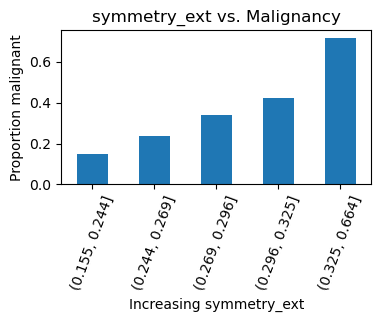

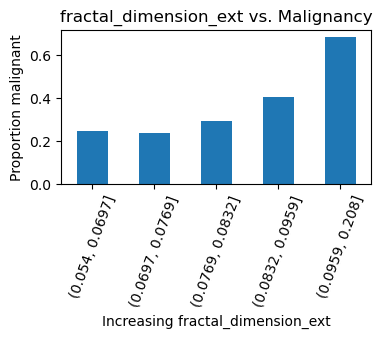

In [77]:
df_m = df.Diagnosis==True
for feat in df.columns[1:]:
    bins = pd.qcut(df[feat],5,duplicates='drop')
    bins_arr = np.array(bins,dtype=object)
    #bins_round = [pd.Interval(int(np.round(i.left, decimals=3)),int(np.round(i.right, decimals=3))) for i in bins_arr]
    feat_df = pd.DataFrame(list(zip(df_m.values,bins_arr))).groupby(1).mean()
    feat_df.plot(kind='bar',title=feat + ' vs. Malignancy',legend=False,xlabel='Increasing '+feat,
                 ylabel='Proportion malignant',figsize=(4,2),rot=70);

In [ ]:
a_bins = pd.qcut(df['area_ext'],5,duplicates='drop',labels=['1: 185 - 476','2: 476 - 600','3: 600 - 781','4: 781 - 1269',
                                                            '5: 1269 - 4254'])
a_bins_arr = np.array(a_bins, dtype=object)
a_df = pd.DataFrame(list(zip(df_m.values, a_bins_arr)), columns=['mean freq','bin']).sort_index().groupby('bin').mean()
a_df.plot(kind='bar',title='Worst area vs. malignancy',legend=False,xlabel='Increasing worst area, in pixels',
         ylabel = 'Proportion of malignant cases',figsize=(6,3));

In [ ]:
b_bins = pd.qcut(df['concave_points_ext'],5,duplicates='drop',labels=['1: 0 - .06','2: .06 - .08','3: .08 - .12','4: .12 - .18',
                                                            '5: .18 - .29'])
b_bins_arr = np.array(b_bins, dtype=object)
b_df = pd.DataFrame(list(zip(df_m.values, b_bins_arr)), columns=['mean freq','bin']).sort_index().groupby('bin').mean()
b_df.plot(kind='bar',title='Worst concave points vs. malignancy',legend=False,xlabel='Increasing worst concave points, by count',
         ylabel = 'Proportion of malignant cases',figsize=(6,3));

In [ ]:
c_bins = pd.qcut(df['symmetry'],5,duplicates='drop',labels=['1: .052 - .084','2: .084 - .092','3: .092 - .099','4: .099 - .108',
                                                            '5: .108 - .163'])

c_bins_arr = np.array(c_bins, dtype=object)
c_df = pd.DataFrame(list(zip(df_m.values, c_bins_arr)), columns=['mean freq','bin']).sort_index().groupby('bin').mean()
c_df.plot(kind='bar',title='Symmetry vs. malignancy',legend=False,xlabel='Increasing symmetry',
         ylabel = 'Proportion of malignant cases',figsize=(6,3));

In [ ]:
d_bins = pd.qcut(df['fractal_dimension_ext'],5,duplicates='drop',labels=['1: .054 - .070','2: .070 - .077','3: .077 - .083',
                                                                         '4: .083 - .096','5: .096 - .208'])

d_bins_arr = np.array(d_bins, dtype=object)
d_df = pd.DataFrame(list(zip(df_m.values, c_bins_arr)), columns=['mean freq','bin']).sort_index().groupby('bin').mean()
d_df.plot(kind='bar',title='Worst fractal dimension vs. malignancy',legend=False,
          xlabel='Increasing worst fractal dimension, using coastline approximation',
          ylabel = 'Proportion of malignant cases',figsize=(6,3));

Magnitude of most features is positively correlated with rate of malignancy. Mean fractal dimension is the only exception, but extreme fractal dimension is also positively correlated.
The most strongly predictive features seem to align with the results of the correlation matrix.

In [ ]:
# Random Forest feature importance
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns='Diagnosis'),df.Diagnosis,test_size=0.3)
forest = RandomForestClassifier(random_state=17)
forest.fit(X_train,y_train)

In [58]:
print(f"Accuracy on train set: {forest.score(X_train, y_train):.3f}")
print(f"Accuracy on test set: {forest.score(X_test, y_test):.3f}")

Accuracy on train set: 1.000
Accuracy on test set: 0.965


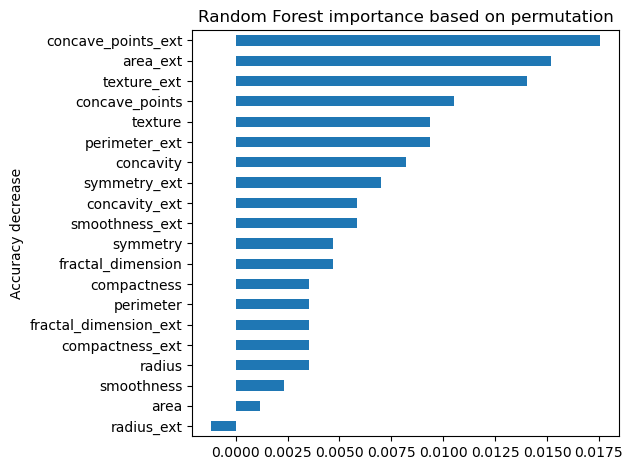

In [80]:
rf_perm = permutation_importance(forest,X_test,y_test,random_state=17)
rf_sortidx = np.argsort(rf_perm.importances_std)
rf_sorted = rf_perm.importances_std[rf_sortidx]

importances_mean = pd.Series(data=rf_perm['importances_mean'],
                             index=df.drop(columns='Diagnosis').columns) #mean perm imp, indxd
#importances_se = rf_perm['importances_std']/np.sqrt(5)
#why is n=5 for std error here? sample size is 20 values no?

fig,ax = plt.subplots()
importances_mean.sort_values(ascending=True).plot.barh(rf_sorted,ax=ax)
# rf_feat_imp.sort_values(ascending=True).plot.barh(rf_sorted,ax=ax)
# rf_feat_imp.plot.barh(rf_sorted,ax=ax)
ax.set_title('Random Forest permutation importances')
ax.set_ylabel('Decrease in accuracy') #interpret as high values, weak predictors
fig.tight_layout()
plt.show()

In [94]:
importances_mean.sort_values(ascending=False).round(decimals=5) * 1000

concave_points_ext       17.54
area_ext                 15.20
texture_ext              14.04
concave_points           10.53
texture                   9.36
perimeter_ext             9.36
concavity                 8.19
symmetry_ext              7.02
concavity_ext             5.85
smoothness_ext            5.85
symmetry                  4.68
fractal_dimension         4.68
radius                    3.51
compactness_ext           3.51
fractal_dimension_ext     3.51
compactness               3.51
perimeter                 3.51
smoothness                2.34
area                      1.17
radius_ext               -1.17
dtype: float64

In [132]:
importances_mean = pd.Series(data=rf_perm['importances_mean'],
                             index=df.drop(columns='Diagnosis').columns)
perm_sorted = importances_mean.sort_values(ascending=False).round(decimals=5)
perm_sorted.index

Index(['concave_points_ext', 'texture_ext', 'concavity', 'texture',
       'radius_ext', 'concave_points', 'perimeter_ext', 'smoothness_ext',
       'smoothness', 'symmetry_ext', 'area_ext', 'concavity_ext', 'area',
       'perimeter', 'compactness_ext', 'radius', 'fractal_dimension',
       'symmetry', 'compactness', 'fractal_dimension_ext'],
      dtype='object')

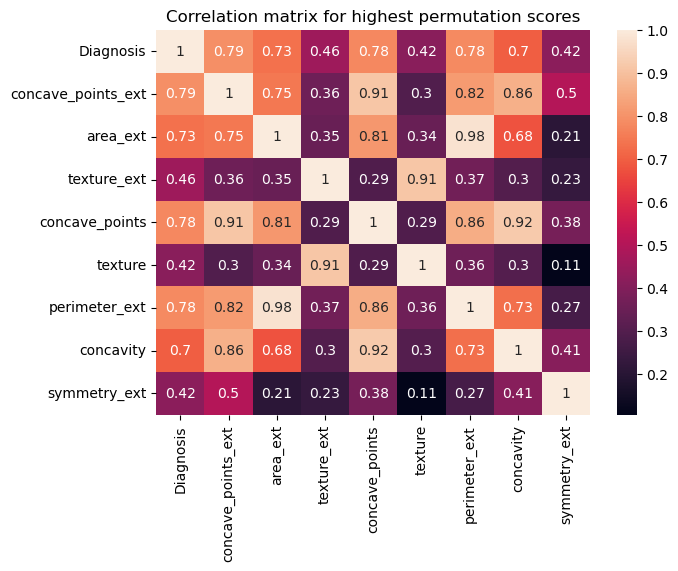

In [201]:
idx_ls = list(importances_mean.sort_values(ascending=False).index[0:8])
idx_ls.insert(0,'Diagnosis')
high_perm = pd.DataFrame(df[idx_ls])

plt.subplots(figsize=(7,5))
sns.heatmap(high_perm.corr(numeric_only=True),annot=True).set(title='Correlation matrix for highest permutation scores');

Some consistency with previous visualizations but compactness does not seem to be as important a feature as the correlation matrix showed.

Top 8 features based on permutation importances, in order: worst concave points, worst area, worst texture, concave points, texture, worst perimeter, concavity, and worst symmetry

Some collinearities between these top 8 features observed. Keeping highly collinear features in the regression may skew the model.

Option to train/test a few models with different combinations of these features and keep the highest performing? Ask at next mentor call (how could I go about deciding these groupings?)

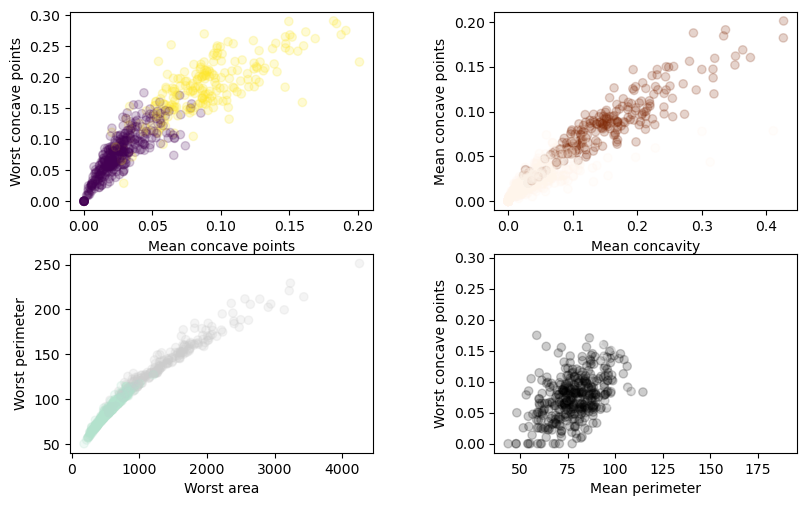

In [40]:
figsc, axsc = plt.subplots(2,2, figsize=(8,5))
figsc.tight_layout()
plt.subplots_adjust(wspace=.4)

axsc[0,0].scatter(df['concave_points'], df['concave_points_ext'], alpha=0.2,
            c=df.Diagnosis, cmap='viridis')
axsc[0,0].set_xlabel('Mean concave points')
axsc[0,0].set_ylabel('Worst concave points')

axsc[0,1].scatter(df['concavity'], df['concave_points'], alpha=0.2,
            c=df.Diagnosis, cmap='Oranges')
axsc[0,1].set_xlabel('Mean concavity')
axsc[0,1].set_ylabel('Mean concave points')

axsc[1,0].scatter(df['area_ext'], df['perimeter_ext'], alpha=0.2,
            c=df.Diagnosis, cmap='Pastel2')
axsc[1,0].set_xlabel('Worst area')
axsc[1,0].set_ylabel('Worst perimeter')

axsc[1,1].scatter(df['perimeter'], df['concave_points_ext'], alpha=0.2,
            c=df.Diagnosis, cmap='afmhot')
axsc[1,1].set_xlabel('Mean perimeter')
axsc[1,1].set_ylabel('Worst concave points')

plt.show()

<Axes: >

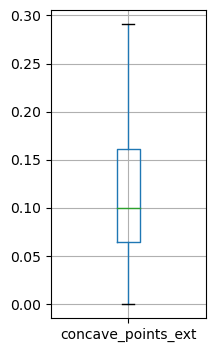

In [196]:
#for feat in idx_ls:
#    df.boxplot([feat], figsize=(3,5), return_type='axes')

df.boxplot(['concave_points_ext'], figsize=(2,4), whis=4, return_type='axes')

<Axes: >

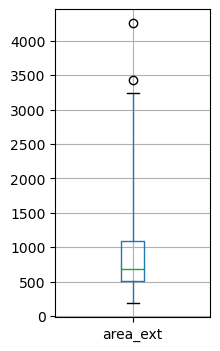

In [195]:
df.boxplot(['area_ext'], figsize=(2,4), whis=4, return_type='axes')